# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format)

Найдем производные регуляций:
$$l_2 = \beta \|w\|_2^2$$
$$l_1 = \gamma \|w\|_1$$

$$\frac{\partial l_1}{\partial w} = sign(w)$$
$$\frac{\partial l_2}{\partial w} = 2\beta w$$

$$\frac{\partial l_2}{\partial w_0} = \frac{\partial l_1}{\partial w_0} = 0$$


Градиент для функции потерь:
$$GradientL(w, w_0) = (\frac{\partial L}{\partial w_0}; \frac{\partial L}{\partial w_1};...;\frac{\partial L}{\partial w_N})$$

Найдем частные производные:
$$\frac{\partial L}{\partial w_0} = \frac{1}{N} \sum_{i=1}^N \frac{\exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} (-y_i)$$

Пусть $A = \ln(1+\exp(-y_i(w^\top x_i+w_0)))$

$$\frac{\partial A}{\partial w_j} = \frac{\exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} (-y_i)(x_ij); j=1..N$$

$$\frac{\partial A}{\partial w} = \frac{\exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} (-y_i)(x_i)$$

Тогда
$$\frac{\partial L}{\partial w} = \frac{1}{N} \sum_{i=1}^N \frac{\exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} (-y_i)(x_i) + 2\beta w + sign(w)$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    reg1 = gamma * np.sum(np.abs(w))
    reg2 = beta * np.sum(np.square(w))
    under_log = 1 + np.exp(np.multiply(-y, np.dot(X, w) + w0))

    return (1 / np.shape(X)[0]) * np.sum(np.log(under_log)) + reg1 + reg2

#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    up = np.exp(np.multiply((-1) * y, np.dot(X, w) + w0))
    down = 1 + np.exp(np.multiply((-1) * y, np.dot(X, w) + w0))

    grad_w0 = (1 / np.shape(X)[0]) * np.dot(up / down, (-1) * y)

    derivative_l1 = gamma * np.sign(w)
    derivative_l2 = 2 * beta * w

    grad_w = (1 / np.shape(X)[0]) * np.dot(np.multiply(up / down, (-1) * y),  X) + derivative_l1 + derivative_l2

    return grad_w, grad_w0

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)

assert (np.allclose(grad_w,
                    [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                    rtol=1e-2) & np.allclose(grad_w0,
                                             -0.2078231418067844,
                                             rtol=1e-2)
        )

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from numpy import linalg as la

In [61]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, learning_rate=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state

        self.loss_history = None
        self.w = None
        self.w0 = 0

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.loss_history = []
        w = np.random.normal(0, 1, np.shape(X)[1])
        self.w0 = np.random.normal(0, 1, size=1)
        self.w = w.copy()
        iter_num = 0
        # обычный градиентный спуск
        while iter_num < self.max_iter and abs(la.norm(w - self.w) - self.tolerance) > 0:
            grad_w, grad_w0 = get_grad(X, y, w, self.w0, self.gamma, self.beta)
            self.loss_history = np.append(self.loss_history, loss(X, y, self.w, self.w0, self.gamma, self.beta))
            self.w = w
            w -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0
            iter_num += 1
        self.w = w


    def predict(self, X):
        probabilities = self.predict_proba(X)
        res = np.argmax(probabilities, axis=0)
        res[res == 0] = -1
        return res

    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)), 1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])

In [62]:
# sample data to test your model
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

In [63]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)

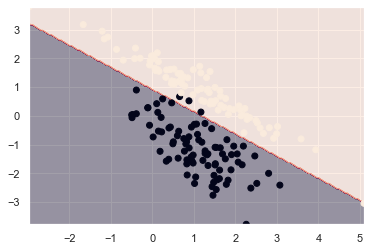

In [65]:
# model = Logit(0, 0, max_iter=10000, tolerance=0.00001, lr=0.01)
model = Logit(0, 0, learning_rate=0.01, max_iter=20000)
y[y == 0] = -1
model.fit(X, y)

plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0.5, 1.0, 'Dependence of the loss function from the iteration number')

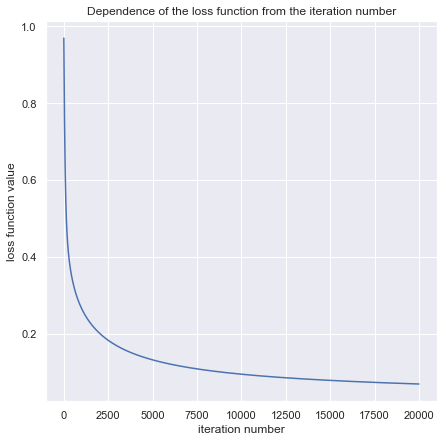

In [10]:
plt.figure(1, figsize=(7,7))
plt.plot(model.loss_history)
plt.xlabel("iteration number")
plt.ylabel("loss function value")
plt.title("Dependence of the loss function from the iteration number")

Summary:  с каждой итерацией значение функции потерь становится меньше.

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import *

In [12]:
def show_results(test_y, pred, proba, kernel):
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:, 1]), ))
    print('\n')
    labels = ['negative', 'positive']

    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels,
                yticklabels=labels)
    plt.title(f"Confusion matrix for {kernel} model")
    plt.show()

In [13]:
reg_coef = np.linspace(0.0001, 1, num=100)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=13)

Сначала попробуем сравнить метрики моделей с разными ядрами

F1-measure:   0.96
Accuracy:   0.96
ROC-AUC  =    1.00




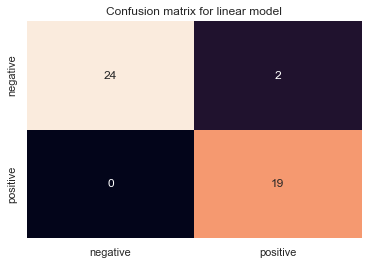

F1-measure:   0.96
Accuracy:   0.96
ROC-AUC  =    1.00




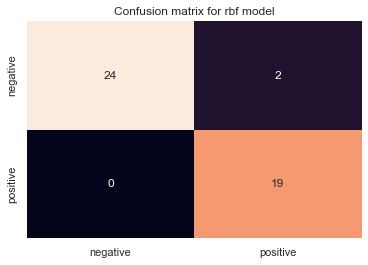

F1-measure:   1.00
Accuracy:   1.00
ROC-AUC  =    1.00




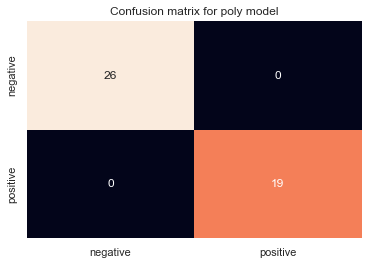

In [14]:
clf = SVC(kernel='linear', probability=True)
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
probabilities = clf.predict_proba(x_test)
show_results(y_test, prediction, probabilities, 'linear')

clf = SVC(kernel='rbf', probability=True)
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
probabilities = clf.predict_proba(x_test)
show_results(y_test, prediction, probabilities, 'rbf')

clf = SVC(kernel='poly', probability=True)
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
probabilities = clf.predict_proba(x_test)
show_results(y_test, prediction, probabilities, 'poly')

Модели со всеми ядрами показывают хорошую точность.
Скорее всего к переобучению склона модель с полиномиальным ядром, так как ее предсказание вообще не содержит ошибок.

Теперь посмотрим, каким образом коэффицент регуляции влияет на качество моделей с разными ядрами.

In [15]:
def get_scores(input_kernel):
    f1s = []
    roc_auc_s = []
    accuracy_s = []
    for coef in reg_coef:
        clf = SVC(kernel=input_kernel, probability=True, C=coef)
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_test)
        probabilities = clf.predict_proba(x_test)
        f1s.append(f1_score(y_test, prediction, average='macro'))
        roc_auc_s.append(roc_auc_score(y_test, probabilities[:, 1]))
        accuracy_s.append(accuracy_score(y_test, prediction))
    return f1s, roc_auc_s, accuracy_s

In [16]:
f1s_linear, roc_auc_linear, accuracy_s_linear = get_scores('linear')
f1s_poly, roc_auc_poly, accuracy_s_poly = get_scores('poly')
f1s_rbf, roc_auc_rbf, accuracy_s_rbf = get_scores('rbf')

Text(0.5, 1.0, 'Regularization coefficient influence on RBF kernel metrics')

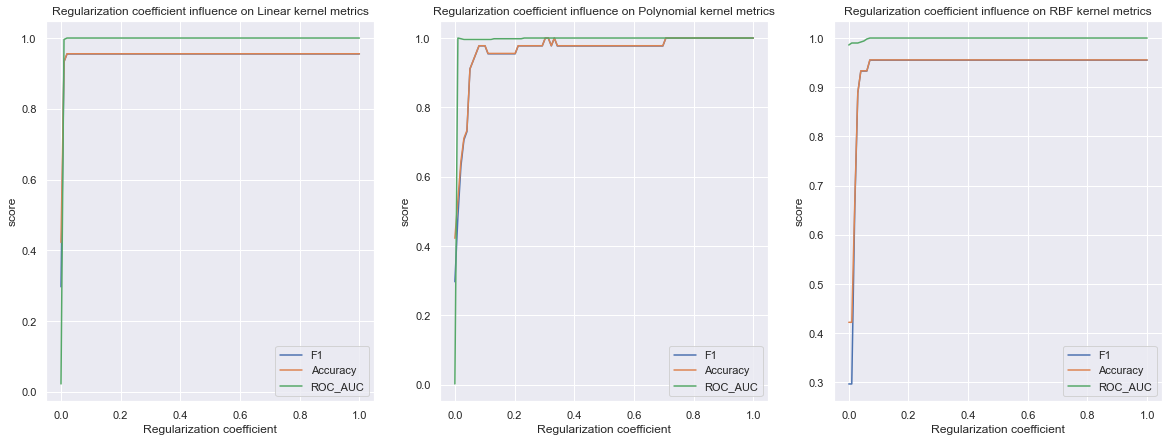

In [17]:
plt.figure(1, figsize=(20,7))
plt.subplot(131)
plt.plot(reg_coef, f1s_linear)
plt.plot(reg_coef, accuracy_s_linear)
plt.plot(reg_coef, roc_auc_linear)
plt.legend(["F1", "Accuracy", "ROC_AUC"])
plt.xlabel("Regularization coefficient")
plt.ylabel("score")
plt.title("Regularization coefficient influence on Linear kernel metrics")

plt.subplot(132)
plt.plot(reg_coef, f1s_poly)
plt.plot(reg_coef, accuracy_s_poly)
plt.plot(reg_coef, roc_auc_poly)
plt.legend(["F1", "Accuracy", "ROC_AUC"])
plt.xlabel("Regularization coefficient")
plt.ylabel("score")
plt.title("Regularization coefficient influence on Polynomial kernel metrics")

plt.subplot(133)
plt.plot(reg_coef, f1s_rbf)
plt.plot(reg_coef, accuracy_s_rbf)
plt.plot(reg_coef, roc_auc_rbf)
plt.legend(["F1", "Accuracy", "ROC_AUC"])
plt.xlabel("Regularization coefficient")
plt.ylabel("score")
plt.title("Regularization coefficient influence on RBF kernel metrics")

Для всех моделей верно, что начиная с какого-то определенного коэффицента регуляции метрики находятся на постоянном высоком уровне (примерно начиная с С=0.01).
Наиболее чувствительна к коэффиценту регуляции модель с полиномиальным ядром, так как на графике видны скачки Accuracy.

Исследуем влияние гиперпараметра gamma на качество RBF модели.

In [18]:
gamma = np.linspace(0.0001, 0.1, num=100)
def get_scores_rbf_gamma():
    f1s = []
    roc_auc_s = []
    accuracy_s = []
    for g in gamma:
        clf = SVC(kernel='rbf', probability=True, gamma=g)
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_test)
        probabilities = clf.predict_proba(x_test)
        f1s.append(f1_score(y_test, prediction, average='macro'))
        roc_auc_s.append(roc_auc_score(y_test, probabilities[:, 1]))
        accuracy_s.append(accuracy_score(y_test, prediction))
    return f1s, roc_auc_s, accuracy_s

Text(0.5, 1.0, 'Gamma influence on RBF kernel metrics')

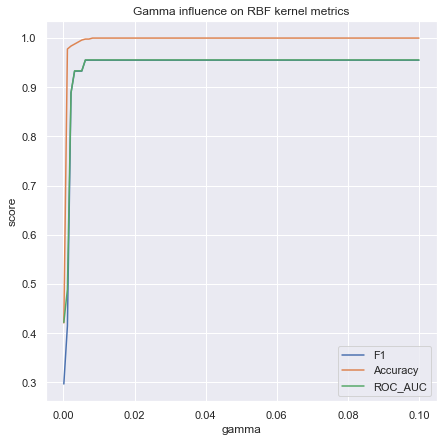

In [19]:
f1s_rbf_gamma, roc_auc_rbf_gamma, accuracy_s_rbf_gamma = get_scores_rbf_gamma()

plt.figure(1, figsize=(7, 7))
plt.plot(gamma, f1s_rbf_gamma)
plt.plot(gamma, roc_auc_rbf_gamma)
plt.plot(gamma, accuracy_s_rbf_gamma)
plt.legend(["F1", "Accuracy", "ROC_AUC"])
plt.xlabel("gamma")
plt.ylabel("score")
plt.title("Gamma influence on RBF kernel metrics")

На графике видно, что начиная со значения gamma~0.005 значение метрик практически не меняется.
При этом на значениях gamma очень близких к нулю качество модели низкое.

 Исследуем влияние гиперпараметра degree на качество полиномиальной модели.

In [20]:
degree = [2, 3, 4, 5, 6]

def get_scores_poly_degree():
    f1s = []
    roc_auc_s = []
    accuracy_s = []
    for d in degree:
        clf = SVC(kernel='poly', probability=True, degree=d)
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_test)
        probabilities = clf.predict_proba(x_test)
        f1s.append(f1_score(y_test, prediction, average='macro'))
        roc_auc_s.append(roc_auc_score(y_test, probabilities[:, 1]))
        accuracy_s.append(accuracy_score(y_test, prediction))
    return f1s, roc_auc_s, accuracy_s

Text(0.5, 1.0, 'Degree influence on Poly kernel metrics')

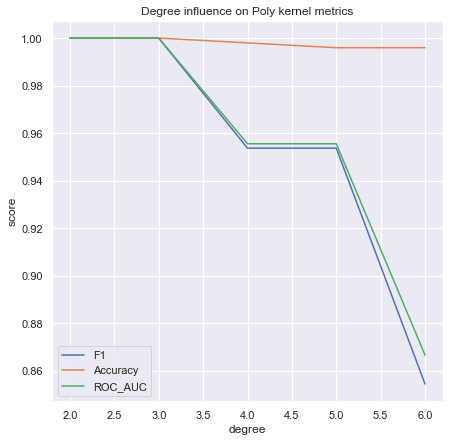

In [21]:
f1s_poly_d, roc_auc_poly_d, accuracy_s_poly_d = get_scores_poly_degree()

plt.figure(1, figsize=(7, 7))
plt.plot(degree, f1s_poly_d)
plt.plot(degree, roc_auc_poly_d)
plt.plot(degree, accuracy_s_poly_d)
plt.legend(["F1", "Accuracy", "ROC_AUC"])
plt.xlabel("degree")
plt.ylabel("score")
plt.title("Degree influence on Poly kernel metrics")

Модель наиболее точная при степенях равных 2 или 3. Дальнейшее увеличение степени плохо влияет на качество.
Можно предположить, что на качество модели с полиномиальным ядром сильно влияет значение degree.

In [22]:
coef0 = np.linspace(0.0001, 10000, num=100)

def get_scores_poly_coef0():
    f1s = []
    roc_auc_s = []
    accuracy_s = []
    for c in coef0:
        clf = SVC(kernel='poly', probability=True, coef0=c)
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_test)
        probabilities = clf.predict_proba(x_test)
        f1s.append(f1_score(y_test, prediction, average='macro'))
        roc_auc_s.append(roc_auc_score(y_test, probabilities[:, 1]))
        accuracy_s.append(accuracy_score(y_test, prediction))
    return f1s, roc_auc_s, accuracy_s

Text(0.5, 1.0, 'Coef0 (bias) influence on Poly kernel metrics')

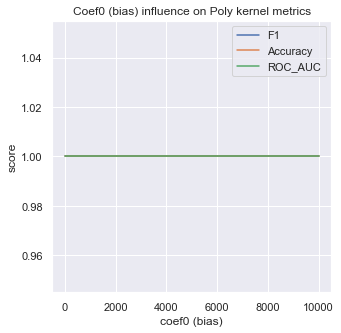

In [23]:
f1s_poly_coef, roc_auc_poly_coef, accuracy_s_poly_coef = get_scores_poly_coef0()

plt.figure(1, figsize=(5, 5))
plt.plot(coef0, f1s_poly_coef)
plt.plot(coef0, roc_auc_poly_coef)
plt.plot(coef0, accuracy_s_poly_coef)
plt.legend(["F1", "Accuracy", "ROC_AUC"])
plt.xlabel("coef0 (bias)")
plt.ylabel("score")
plt.title("Coef0 (bias) influence on Poly kernel metrics")

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

Part 0. Chosen authors: Chekhov, Dostoevsky, Gogol, Gorky, Lermontov, Turgenev

Part 1. Split into sentences and build random dataset

In [24]:
import nltk
import string

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/shmelzzz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# 1
# функция для разделения текста на предложения
def split_sentences(text):
    sentences = np.array(nltk.sent_tokenize(text, language="russian"))
    return sentences

# для создания DataFrame из предложений и их автора
def create_data_frame_from_text(text_path):
    with open(text_path) as f:
        content = f.read()
    sentences = np.array(split_sentences(content))
    myLengthFunc = np.vectorize(len)
    sentences = sentences[np.where(myLengthFunc(sentences) >= 15)]
    author = np.full(sentences.shape[0], authors[text_path.split('/')[1]])
    return pd.DataFrame({'sentence': sentences, 'author': author})

In [26]:
authors = {
    'Chekhov': 'Чехов',
    'Dostoevsky': 'Достоевский',
    'Gogol': 'Гоголь',
    'Gorky': 'Горький',
    'Turgenev': 'Тургенев',
    'Lermontov': 'Лермонтов'
}

In [27]:
import glob

data = pd.DataFrame({'sentence': [], 'author': []})
samples_number = [5000, 15000, 8000, 11000, 20000, 3000]

In [28]:
np.random.seed(42)

# Building dataset
i = 0
for author in authors:
    texts = glob.glob(f"prose/{author}/*.txt")
    data_author = pd.DataFrame({'sentence': [], 'author': []})
    for path in texts:
        data_author = pd.concat([data_author, create_data_frame_from_text(path)], ignore_index=True)
    data = pd.concat([data, data_author.sample(n=samples_number[i])], ignore_index=True)
    i = i + 1

Part 2. Preprocess

In [29]:
# 2
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shmelzzz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
punctuation_arr = ['«', '»', '...', '—', '–']

# returns processed sentence
def process_sentence(text):
    # split sentence into words
    words = nltk.word_tokenize(text, language='russian')
    words = [morph.parse(word.lower())[0].normal_form for word in words]
    tokens = [word for word in words if (
            word not in string.punctuation and word not in stop_words and word not in punctuation_arr and not word.isnumeric())]
    return ' '.join(tokens)

In [31]:
def process(data):
    return process_sentence(data['sentence'])

# update dataset with preprocessed sentences
data['sentence'] = data.apply(process, axis=1)

In [32]:
sentences = data['sentence']

In [33]:
# определим словарь
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 500)
vectorizer.fit(sentences)

vectorized_data_bag = vectorizer.transform(sentences)
# print vectorized dataset sample
print(vectorized_data_bag[:3])

  (0, 43)	1
  (0, 316)	1
  (1, 36)	1
  (2, 56)	1
  (2, 117)	1
  (2, 250)	1
  (2, 293)	1
  (2, 388)	1
  (2, 445)	1


Bag of words: получаем матрицу, хранящую значения, которые показывают количество слов из словаря в каждом предложении датасета (выведен пример матрицы в разреженном виде)

In [34]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
vectorizer = TfidfVectorizer(max_features = 500)
vectorizer.fit(sentences)

vectorized_data_tf = vectorizer.transform(sentences)
# print vectorized dataset sample
print(vectorized_data_tf[:3])

  (0, 316)	0.744405316621984
  (0, 43)	0.6677280318999076
  (1, 36)	1.0
  (2, 445)	0.3702341254231932
  (2, 388)	0.4512798476790932
  (2, 293)	0.4503487956184997
  (2, 250)	0.392018066292048
  (2, 117)	0.3493222475579064
  (2, 56)	0.42515286285941983


TF-IDF: получаем матрицу, хранящую значения, которые показывают отношение числа вхождений некоторого слова к общему числу слов (важность слова) (выведен пример матрицы в разреженном виде)

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


Выбранные авторы: Чехов и Лермонтов. В датасете 5000 предложений Чехова и 3000 предложений Лермонтова, следовательно, классы не совсем сбалансированы, есть перекос в сторону Чехова.

In [35]:
# divide into train and test
from sklearn.model_selection import train_test_split

dataset_chosen = data[data['author'].isin(['Чехов', 'Лермонтов'])]

train_x, test_x, train_y, test_y = train_test_split(dataset_chosen['sentence'],
                                                    [1 if x == 'Чехов' else -1 for x in dataset_chosen['author']],
                                                    test_size=0.3,
                                                    random_state=42)

In [36]:
# преобразуем датасет с помощью tf-idf
train_x_vec = vectorizer.transform(train_x)
test_x_vec  = vectorizer.transform(test_x)

In [123]:
def show_metrics(test_y, pred, proba, kernel):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:, 1]), ))
    print('\n')
    labels = ['Чехов', 'Лермонтов']

    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels,
                yticklabels=labels)
    plt.title(f"Confusion matrix for {kernel} model")
    plt.show()

*SVM*

In [48]:
from sklearn.model_selection import GridSearchCV

# gridsearch for best svm parameters
parameters = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'decision_function_shape': ['ovo', 'ovr']}
svr = SVC(probability=True, verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1', verbose=2, cv=2)
clf.fit(train_x_vec, train_y)
print(clf.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END C=0.001, decision_function_shape=ovo, kernel=linear; total time=   0.9s
[CV] END C=0.001, decision_function_shape=ovo, kernel=linear; total time=   0.9s
[CV] END ...C=0.001, decision_function_shape=ovo, kernel=rbf; total time=   1.1s
[CV] END ...C=0.001, decision_function_shape=ovo, kernel=rbf; total time=   1.0s
[CV] END ..C=0.001, decision_function_shape=ovo, kernel=poly; total time=   1.1s
[CV] END ..C=0.001, decision_function_shape=ovo, kernel=poly; total time=   1.1s
[CV] END C=0.001, decision_function_shape=ovo, kernel=sigmoid; total time=   1.1s
[CV] END C=0.001, decision_function_shape=ovo, kernel=sigmoid; total time=   1.1s
[CV] END C=0.001, decision_function_shape=ovr, kernel=linear; total time=   0.9s
[CV] END C=0.001, decision_function_shape=ovr, kernel=linear; total time=   0.9s
[CV] END ...C=0.001, decision_function_shape=ovr, kernel=rbf; total time=   1.1s
[CV] END ...C=0.001, decision_function_shape=o

Precision:   0.69
Recall:   0.63
F1-measure:   0.63
Accuracy:   0.70
ROC-AUC  =    0.72




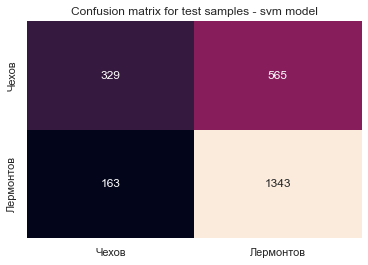

In [49]:
pred = clf.predict(test_x_vec)
proba  = clf.predict_proba(test_x_vec)
show_metrics(test_y, pred, proba, 'test samples - svm')

Precision:   0.75
Recall:   0.68
F1-measure:   0.69
Accuracy:   0.74
ROC-AUC  =    0.78




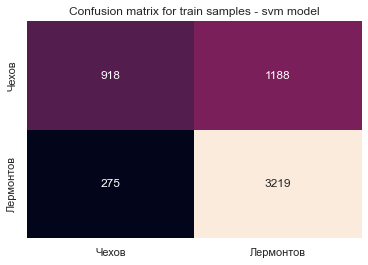

In [50]:
pred = clf.predict(train_x_vec)
proba  = clf.predict_proba(train_x_vec)
show_metrics(train_y, pred, proba, 'train samples - svm')

SVM Summary: в целом модель нормального качества, но все-таки совершает довольно много ошибок.
Модель часто совершает ошибку при определении Лермонтова. Например, на тренировочных данных 1188 раз предложение Лермонтова модель посчитала предложением Чехова. Это отчасти можно объяснить несбалансированностью классов (модель обучалась на большем кол-ве предложений Чехова, чем Лермонтова)

*Logistic Regression*

In [73]:
# тут могло быть больше вариантов параметров, но тогда оно будет работать вечность
parameters = {'learning_rate': [0.01, 0.1, 1], 'max_iter': [30000]}
clf_Logit = GridSearchCV(Logit(beta=0, gamma=0), parameters, scoring = 'f1', verbose=2, cv=2)
clf_Logit.fit(np.array(train_x_vec.todense()), np.array(train_y))
print(clf_Logit.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END .................learning_rate=0.01, max_iter=30000; total time=  56.1s
[CV] END .................learning_rate=0.01, max_iter=30000; total time=  53.5s
[CV] END ..................learning_rate=0.1, max_iter=30000; total time=  55.4s
[CV] END ..................learning_rate=0.1, max_iter=30000; total time=  52.7s
[CV] END ....................learning_rate=1, max_iter=30000; total time=  52.7s
[CV] END ....................learning_rate=1, max_iter=30000; total time=  52.8s
{'learning_rate': 0.1, 'max_iter': 30000}


Precision:   0.69
Recall:   0.64
F1-measure:   0.65
Accuracy:   0.70
ROC-AUC  =    0.72




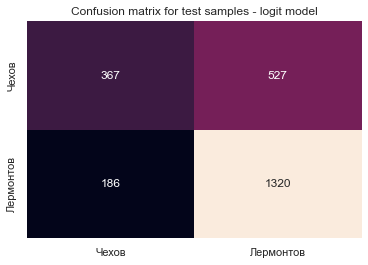

In [126]:
pred = clf_Logit.predict(np.array(test_x_vec.todense()))
proba_logit = clf_Logit.predict_proba(np.array(test_x_vec.todense()))
show_metrics(np.array(test_y), pred, proba_logit.T, 'test samples - logit')

Precision:   0.71
Recall:   0.66
F1-measure:   0.67
Accuracy:   0.72
ROC-AUC  =    0.77




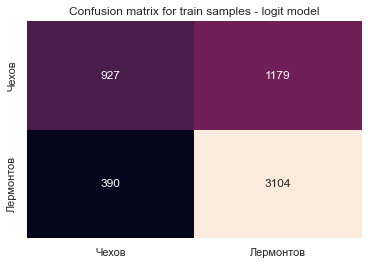

In [127]:
pred = clf_Logit.predict(np.array(train_x_vec.todense()))
proba_logit = clf_Logit.predict_proba(np.array(train_x_vec.todense()))
show_metrics(np.array(train_y), pred, proba_logit.T, 'train samples - logit')

Logistic Regression Summary: в целом предсказывает нормально, но совершает немного больше ошибок, чем SVM модель

Построим графики зависимости f1-score от параметров модели.

Text(0.5, 1.0, 'Learning rate influence on logit model f1-score with max_iter = 30000')

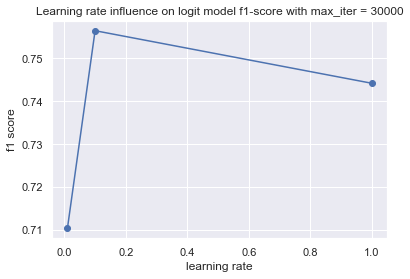

In [98]:
cv_results_logit = clf_Logit.cv_results_
parameters_logit = {'learning_rate': [0.01, 0.1, 1], 'max_iter': [30000]}
f1_scores_mean = cv_results_logit['mean_test_score']
f1_scores_mean = np.array(f1_scores_mean).reshape(len(parameters_logit['learning_rate']),
                                                  len(parameters_logit['max_iter']))

plt.plot(parameters_logit['learning_rate'], f1_scores_mean, '-o')
plt.xlabel("learning rate")
plt.ylabel("f1 score")
plt.title("Learning rate influence on logit model f1-score with max_iter = 30000")

Text(0.5, 1.0, 'Regularization coefficient influence on svm model f1-score')

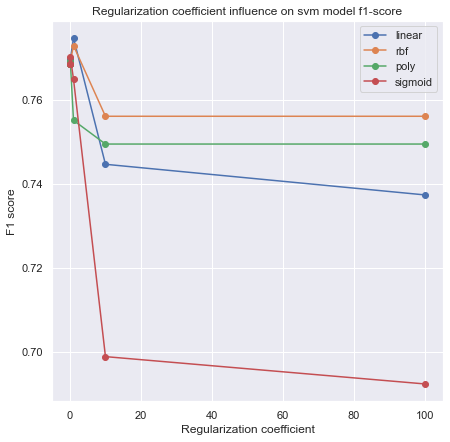

In [114]:
cv_results_svm = clf.cv_results_
parameters_svm = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'decision_function_shape': ['ovo', 'ovr']}

metrics = pd.DataFrame(cv_results_svm)
metrics = metrics[metrics['param_decision_function_shape'] == 'ovo']

metrics_linear = metrics[metrics['param_kernel'] == 'linear']['mean_test_score']
metrics_rbf = metrics[metrics['param_kernel'] == 'rbf']['mean_test_score']
metrics_poly = metrics[metrics['param_kernel'] == 'poly']['mean_test_score']
metrics_sigmoid = metrics[metrics['param_kernel'] == 'sigmoid']['mean_test_score']

plt.figure(1, figsize=(7,7))
plt.plot(parameters_svm['C'], metrics_linear, '-o')
plt.plot(parameters_svm['C'], metrics_rbf, '-o')
plt.plot(parameters_svm['C'], metrics_poly, '-o')
plt.plot(parameters_svm['C'], metrics_sigmoid, '-o')
plt.legend(['linear', 'rbf', 'poly', 'sigmoid'])
plt.xlabel("Regularization coefficient")
plt.ylabel("F1 score")
plt.title("Regularization coefficient influence on svm model f1-score")

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [186]:
def find_threshold_index(fpr, error_rate):
    return np.where(fpr < error_rate)

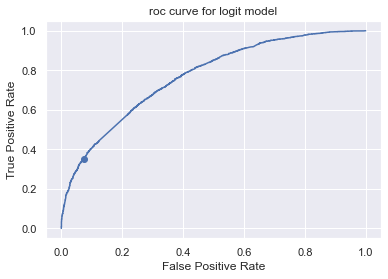

In [201]:
proba_logit = clf_Logit.predict_proba(np.array(train_x_vec.todense()))
fp_logit, tp_logit, thresholds_logit = roc_curve(train_y, proba_logit.T[:, 1])
plt.plot(fp_logit, tp_logit)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc curve for logit model')

# threshold
indexes = find_threshold_index(fp_logit, error_rate=0.3)[0]
threshold_index = indexes[np.random.randint(low=0, high=len(indexes))]
plt.scatter(fp_logit[threshold_index], tp_logit[threshold_index])

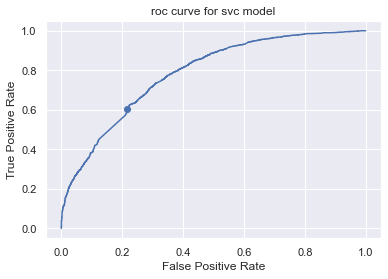

In [207]:
proba_svc = clf.predict_proba(train_x_vec)
fp_svc, tp_svc, thresholds_svc = roc_curve(train_y, proba_svc[:, 1])
plt.plot(fp_svc, tp_svc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc curve for svc model')

# threshold
indexes = find_threshold_index(fp_svc, error_rate=0.3)[0]
threshold_index = indexes[np.random.randint(low=0, high=len(indexes))]
plt.scatter(fp_svc[threshold_index], tp_svc[threshold_index])

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [208]:
authors_encoded = {
    'Чехов': 0,
    'Достоевский': 1,
    'Гоголь': 2,
    'Горький': 3,
    'Тургенев': 4,
    'Лермонтов': 5
}

# split dataset
train_x_all, test_x_all, train_y_all, test_y_all = train_test_split(data['sentence'],
                                                                    [authors_encoded[x] for x in data['author']],
                                                                    test_size=0.3,
                                                                    random_state=42)

In [209]:
train_x_vec_all = vectorizer.transform(train_x_all)
test_x_vec_all  = vectorizer.transform(test_x_all)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

parameters_one_vc_one = {'estimator__learning_rate': [0.01, 0.1, 1], 'estimator__max_iter': [30000]}
my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')

svr_one_vs_one = OneVsOneClassifier(Logit(beta=0, gamma=0))
clf_Logit_one_vs_one = GridSearchCV(svr_one_vs_one, parameters_one_vc_one, scoring = my_scorer, verbose=2, cv=2)
clf_Logit_one_vs_one.fit(np.array(train_x_vec_all.todense()), np.array(train_y_all))
print(clf_Logit_one_vs_one.best_params_)

In [ ]:
def show_metrics_one_vs_one (test_y, pred, proba, kernel):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:, 1]), ))
    print('\n')
    labels = ['Чехов', 'Достоевский', 'Гоголь', 'Горький', 'Тургенев', 'Лермонтов']

    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels,
                yticklabels=labels)
    plt.title(f"Confusion matrix for {kernel} model")
    plt.show()

In [ ]:
pred_all = clf_Logit.predict(np.array(test_x_vec_all.todense()))
proba_all = clf_Logit.predict_proba(np.array(test_x_vec_all.todense()))
show_metrics_one_vs_one(np.array(test_y), pred_all, proba_all.T, 'test samples - logit')

In [ ]:
pred_all = clf_Logit.predict(np.array(train_x_vec_all.todense()))
proba_all = clf_Logit.predict_proba(np.array(train_x_vec_all.todense()))
show_metrics_one_vs_one(np.array(train_y), pred_all, proba_all.T, 'test samples - logit')